# # Lu 177 adjust spectrum and calibration (Source, plastic vial 1 mL)

In [89]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as plb
import scipy as scipy
import pandas as pd
import numpy as np

from scipy import optimize
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline


In [90]:
data = np.genfromtxt('dataLu177_1.txt')
x = np.genfromtxt('dataLu177_1.txt',usecols=(0))
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + offset)
def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return three_gaussians(x, h1, c1, w1, h2, c2, w2, 0,0,1, offset)

In [91]:
errfunc3 = lambda p, x, y: (three_gaussians(x, *p) - y)**2
errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2

In [92]:
guess3 = [13633, 114, 10, 10000, 212, 10, 2000, 150, 150, 0]  # I guess there are 3 peaks, 2 are clear, but between them there seems to be another one, based on the change in slope smoothness there
guess2 = [13633, 114, 10, 10000, 212, 10, 0]  # I removed the peak I'm not too sure about
guess1 = [10000, 212, 10, -100]  # I removed the peak I'm not too sure about
optim3, success = optimize.leastsq(errfunc3, guess3[:], args=(data[:,0], data[:,1]))
optim2, success = optimize.leastsq(errfunc2, guess2[:], args=(data[:,0], data[:,1]))
optim1, success = optimize.leastsq(errfunc1, guess1[:], args=(data[:,0], data[:,1]))

perr_3gauss = np.sqrt(np.diag(optim3))

pars_1 = optim2[0:3]
pars_2 = optim2[3:6]
pars_3 = optim3[6:9]

print(optim2)

gauss_peak_1 = gaussian(x, *pars_1,0)
gauss_peak_2 = gaussian(x, *pars_2,0)
gauss_peak_3 = gaussian(x, *pars_3,0)

[1.18466419e+04 1.13206340e+02 5.58744430e+00 7.88986628e+03
 2.09107342e+02 8.40788585e+00 1.88773962e+03]


In [93]:
# this cell prints the fitting parameters with their errors
print ("-------------Peak 1-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (pars_1 [0],perr_3gauss[0,0]))
print ("center = %0.2f (+/-) %0.2f" % (pars_1 [1], perr_3gauss[1,1]))
print ("sigma = %0.2f (+/-) %0.2f" % (pars_1 [2], perr_3gauss[2,2]))
print ("area = %0.2f" % np.trapz(gauss_peak_1))
print ("--------------------------------")
print ("-------------Peak 2-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (pars_2 [0], perr_3gauss[3,3]))
print ("center = %0.2f (+/-) %0.2f" % (pars_2 [1], perr_3gauss[4,4]))
print ("sigma = %0.2f (+/-) %0.2f" % (pars_2 [2], perr_3gauss[5,5]))
print ("area = %0.2f" % np.trapz(gauss_peak_2))
print ("--------------------------------")
print ("-------------Peak 3-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (optim3 [6], perr_3gauss[6,6]))
print ("center = %0.2f (+/-) %0.2f" % (optim3 [7], perr_3gauss[7,7]))
print ("sigma = %0.2f (+/-) %0.2f" % (optim3 [8], perr_3gauss[8,8]))
print ("area = %0.2f" % np.trapz(gauss_peak_3))
print ("--------------------------------")


-------------Peak 1-------------
amplitude = 11846.64 (+/-) 112.76
center = 113.21 (+/-) 10.64
sigma = 5.59 (+/-) 2.51
area = 89836.41
--------------------------------
-------------Peak 2-------------
amplitude = 7889.87 (+/-) 93.08
center = 209.11 (+/-) 14.46
sigma = 8.41 (+/-) 3.21
area = 83141.22
--------------------------------
-------------Peak 3-------------
amplitude = 12140.73 (+/-) 110.18
center = 57.38 (+/-) 7.57
sigma = 5.43 (+/-) 2.33
area = 89985.49
--------------------------------


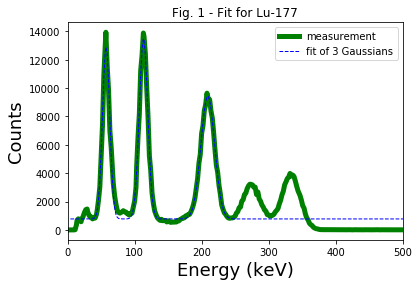

In [97]:
plt.plot(data[:,0], data[:,1], lw=5, c='g', label='measurement')
#plt.plot(data[:,0], three_gaussians(data[:,0], *optim3),
   # lw=3, c='b', label='fit of 3 Gaussians')
#plt.plot(data[:,0], two_gaussians(data[:,0], *optim2),
  #  lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.plot(data[:,0], three_gaussians(data[:,0], *optim3),
    lw=1, c='b', ls='--', label='fit of 3 Gaussians')
plt.title('Fig. 1 - Fit for Lu-177')
plt.xlabel('Energy (keV)', fontsize=18)
plt.ylabel('Counts' , fontsize=18)
plt.legend(loc='best')
plt.xlim((0,500))
plt.savefig('resultLu177_1.png')

In [98]:
err3 = np.sqrt(errfunc3(optim3, data[:,0], data[:,1])).sum()
err2 = np.sqrt(errfunc2(optim2, data[:,0], data[:,1])).sum()
print('Residual error when fitting 3 Gaussians: {}\n'
    'Residual error when fitting 2 Gaussians: {}'.format(err3, err2))

Residual error when fitting 3 Gaussians: 759971.8127006269
Residual error when fitting 2 Gaussians: 1790733.2575948355


In [104]:
#Efficiency based on peak 2 in cps / kBq 
#Efficiency_Peak2 = (np.trapz(gauss_peak_2)/0.1036)/(32.9733976)#Activity at the measuring time
#print (Efficiency_Peak2)

#Efficiency based on peak 2 in cps / kBq 
counts = (np.trapz(gauss_peak_2))
cps = (counts/121.62)
print ("Counts per second = %0.2f" % cps)
Efficiency_Peak2 = (cps/0.1036)/(32.9733976)#Activity at the measuring time
print ("Efficiency = %0.2f" %Efficiency_Peak3)

Counts per second = 683.61
Efficiency = 1.39
